In [6]:
import sklearn as skl
print(skl.__version__)
import gzip
import cloudpickle as pickle
import os
import esaWells
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

0.19.0


In [7]:
def load_data(filename):
    with gzip.GzipFile(filename, 'rb') as f:
        return pickle.load(f)

Having loaded well logs compute features

In [8]:
#data = load_data(os.path.join('..','SLCInput.esa'))
data = load_data(os.path.join('../../','augData.esa'))


In [10]:
data.dropna(inplace=True)
#feat_cols=[col for col in data.columns if col not in [u'idWlb', u'MD', u'DT', u'DEN', u'NEU', u'RDEP', u'GR', u'FM']]
feat_cols=[col for col in data.columns if col not in [u'idWlb', u'MD', u'DT', u'DEN', u'NEU', u'RDEP', u'GR', u'FM']]

features=data[feat_cols]
labels=data[ u'FM']
wells=data[ u'idWlb']
MD=data[ u'MD']

features.describe()

,DT_1001_05,NEU_1001_05,RDEP_1001_05,GR_1001_05,DEN_1001_05,aug0,aug1,aug2,aug3,aug4,...,aug25,aug26,aug27,aug28,aug29,aug30,aug31,aug32,aug33,aug34
count,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,...,4.100800e+05,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000,410080.000000
mean,-9.028814,-0.077345,0.578771,-25.345210,-0.163146,0.013413,-0.027630,-9.028880,-9.103002,2.592252,...,6.789432e+00,-36.108811,-35.897103,-0.000020,0.000449,-0.163147,-0.164061,0.039881,-0.223968,-0.222818
std,7.101386,0.057736,0.279135,22.920313,0.153886,4.528344,0.673170,6.159748,6.300635,2.399266,...,6.482645e+00,27.491419,27.356959,0.076298,0.629763,0.141043,0.145660,0.046882,0.166887,0.166280
min,-103.718750,-0.722555,0.000434,-548.637102,-1.412210,-53.815551,-1.000000,-94.131490,-96.684375,0.000000,...,7.105427e-15,-548.584552,-547.638652,-0.967979,-1.000000,-1.327041,-1.315410,0.000000,-1.412098,-1.410078
25%,-12.514750,-0.107150,0.374063,-34.191949,-0.223800,-1.881353,-0.703231,-12.008274,-12.143282,1.017147,...,3.015086e+00,-44.778081,-44.520563,-0.022213,-0.608567,-0.217527,-0.219900,0.013026,-0.285036,-0.283581
50%,-8.008279,-0.069780,0.582037,-21.522552,-0.135700,-0.082666,-0.053013,-7.996090,-8.012812,1.853339,...,4.981627e+00,-30.883704,-30.707197,0.000058,0.002378,-0.136185,-0.136335,0.024829,-0.191140,-0.190174
75%,-4.589600,-0.039675,0.770591,-11.115491,-0.063200,1.801039,0.651382,-4.960715,-4.944576,3.344419,...,8.401100e+00,-20.005109,-19.860300,0.022629,0.608211,-0.069015,-0.066970,0.048238,-0.111185,-0.110433
max,48.399288,0.341600,14.695000,91.426102,0.987490,69.248097,1.000000,31.839262,32.464100,38.654724,...,1.587655e+02,20.362702,20.465367,0.958261,1.000000,0.835042,0.865800,0.592988,0.639926,0.640574


In [5]:

subsample = features.copy()
subsample.drop(features.index, inplace=True)

for well in wells.unique():
    idxWell = wells.loc[wells==well].index
    thisWell=features.loc[idxWell]
    subsample = subsample.append(thisWell.iloc[np.random.randint(0,len(thisWell), 1000),:])

from sklearn.preprocessing import RobustScaler
#X = RobustScaler().fit_transform(X)
Xsub = RobustScaler().fit_transform(subsample)

How many dimensations unique codes should be in out code book?

wWe can try and estimate that by running kmeans mulitple times on a subbset of our input and looking at the AIC metric

In [37]:
def power2range(n):
    return [1 << i for i in range(n)]

In [40]:
from sklearn.mixture import GaussianMixture

#x = features
x = Xsub
aic = []

kn = power2range(11)[2:]

for k in kn:
    print k
    model = GaussianMixture(n_components=k, init_params='kmeans')
    model.fit(x)
    aic.append(model.aic(x))
    
plt.plot(kn, aic)

4
8
16
32
64
128


/usr/local/lib/python2.7/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


256


KeyboardInterrupt: 

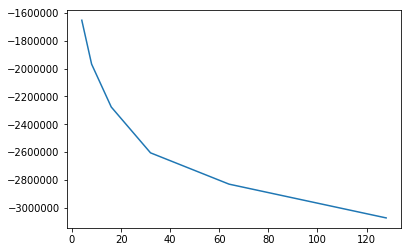

In [42]:
plt.plot(kn[0:len(aic)], aic)

Quantise the symbolic space into k code words

In [6]:
from sklearn.cluster import KMeans

In [7]:
nClusters = 128

In [8]:
quantiser = KMeans(n_clusters=nClusters, random_state=0,n_jobs=-2,verbose=3).fit(features)

Initialization complete
start iteration
done sorting
Initialization complete
Initialization complete
end inner loop
Initialization complete
Initialization complete
Initialization complete
start iteration
done sorting
Initialization complete
start iteration
done sorting
end inner loop
end inner loop
start iteration
done sorting
Iteration 0, inertia 97136495.80747515
start iteration
done sorting
start iteration
done sorting
end inner loop
start iteration
done sorting
end inner loop
end inner loop
start iteration
done sorting
end inner loop
end inner loop
Iteration 0, inertia 97616575.84850222
done sorting
start iteration
Iteration 0, inertia 98375350.58863536
start iteration
done sorting
Iteration 0, inertia 96288345.28159185
start iteration
done sorting
Iteration 0, inertia 97614386.60511896
start iteration
done sorting
Iteration 0, inertia 97445732.42944829
start iteration
done sorting
Iteration 1, inertia 92707134.63173576
start iteration
done sorting
end inner loop
Iteration 0, inert

In [10]:
S = quantiser.predict(features)

In [12]:
with gzip.GzipFile('results', 'w') as fs:
        pickle.dump(features,fs)
        pickle.dump(labels,fs)
        pickle.dump(wells,fs)
        pickle.dump(quantiser,fs)
        pickle.dump(S,fs)
        

In [2]:
with gzip.GzipFile('results', 'r') as fs:
        features=pickle.load(fs)
        labels=pickle.load(fs)
        wells=pickle.load(fs)
        quantiser=pickle.load(fs)
        S=pickle.load(fs)

In [95]:
def resFigs(idWell,data,Predict,otherLogs):
    fig, ax = plt.subplots(nrows=1, ncols=len(otherLogs)+1, sharey=True, figsize=(17, 15))
    idx=data.loc[data.idWlb==idWell].index
    plotData=data.loc[idx,['MD','FM']+otherLogs]
    ax[0].plot(plotData['FM'],plotData['MD'],c='r')
    ax[0].grid()
    ax[0].scatter(Predict,plotData['MD'],s=1)
    for iP,log in enumerate(otherLogs):
            ax[iP+1].grid()
            ax[iP+1].plot(plotData[log],plotData['MD'])
            ax[iP+1].set_title(log)
    ax[0].set_ylim(max(plotData['MD']), min(plotData['MD']))

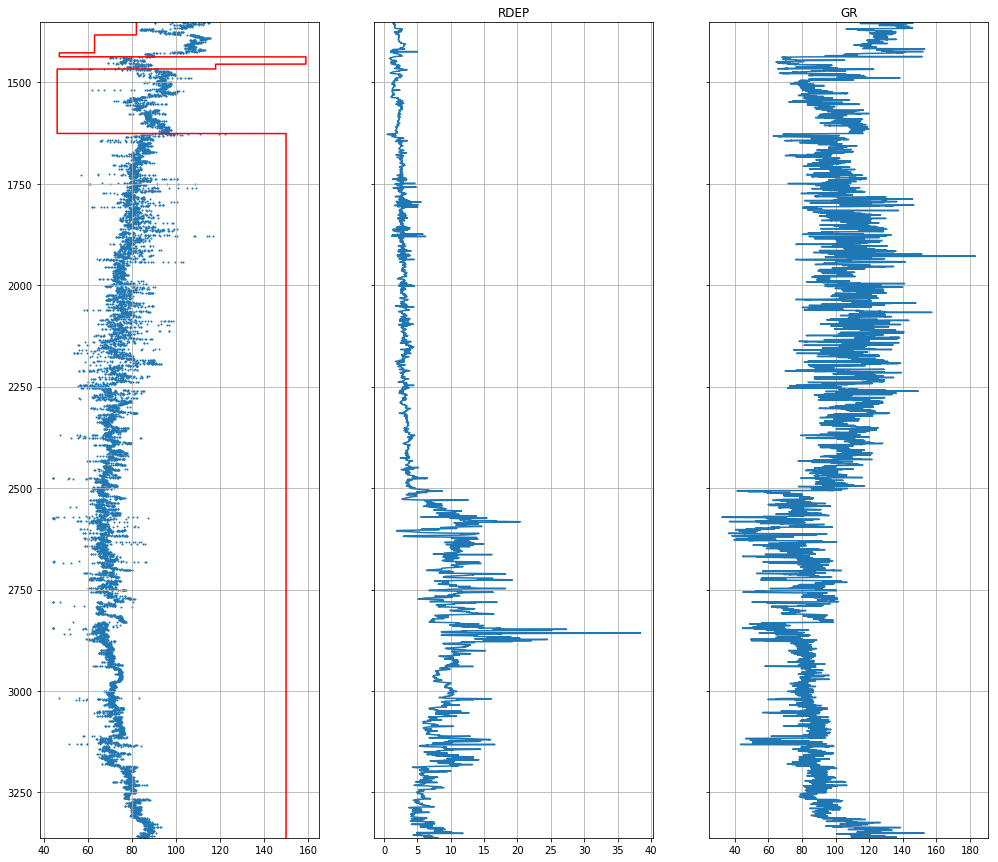

In [96]:
resFigs(1070,data,data.loc[data.idWlb==1070,'DT'],['RDEP','GR'])

0
1
2


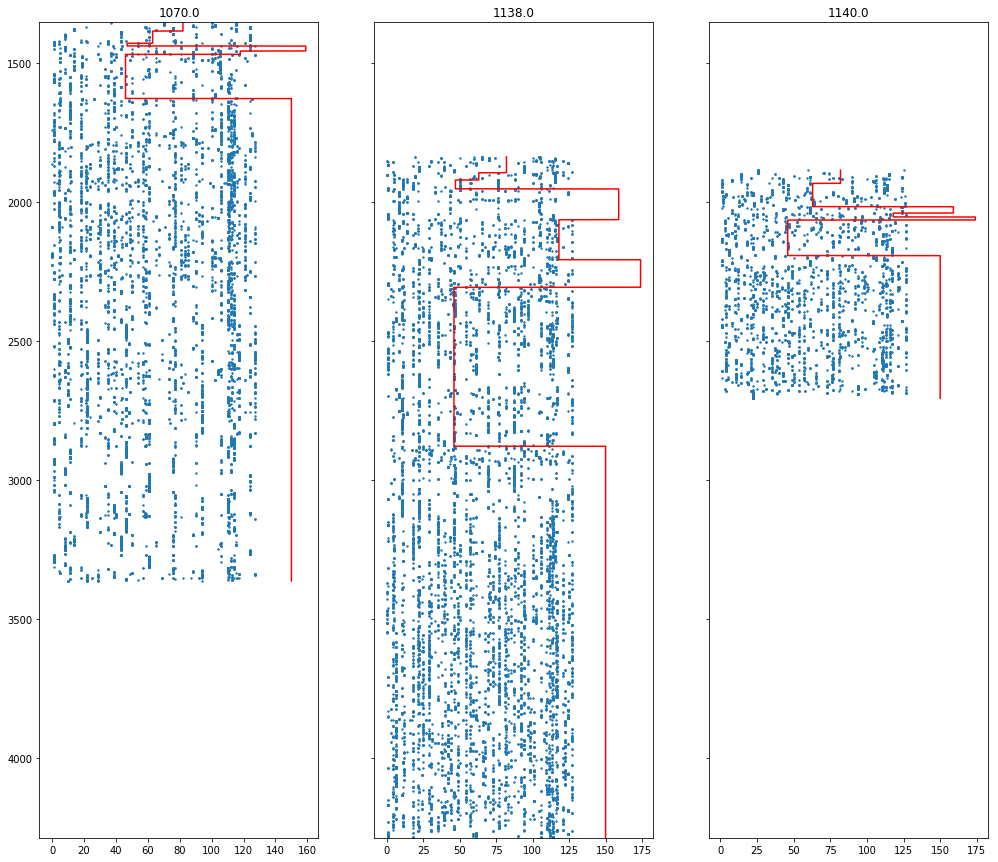

In [83]:
idWells=wells.unique()
#for idWell in idWells:

minMD=100000
maxMD=0
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(17, 15))
for iPlot,idWell in enumerate(idWells[10:13]):
    print iPlot
    idx=wells[wells==idWell].index
    ax[iPlot].scatter(S[idx],MD[idx],s=2)
    maxMD=max(maxMD,max(MD[idx]))
    minMD=min(minMD,min(MD[idx]))
    ax[iPlot].set_title(str(idWell))
    ax[iPlot].plot(labels[idx],MD[idx],c='r')
ax[0].set_ylim(maxMD, minMD)

plt.show()
#    print idWell, len(wells[wells==idWell])
    
    

In [68]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('wells.pdf')
fig.savefig(pp, format='pdf')
pp.close()